<a href="https://colab.research.google.com/github/ikram9820/Fastdl_v3-v5/blob/main/dl2%20v5/stablediffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq diffusers transformers fastcore ftpy


     |████████████████████████████████| 255 kB 31.2 MB/s 
     |████████████████████████████████| 5.3 MB 58.7 MB/s 
     |████████████████████████████████| 163 kB 36.7 MB/s 
     |████████████████████████████████| 7.6 MB 53.6 MB/s 


In [2]:

from PIL import Image
from fastcore.all import concat
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from IPython.display import display 
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from pathlib import Path
import matplotlib.pyplot as plt
import torch, logging
import torchvision.transforms as tfms

from transformers import logging
from torch import autocast
import numpy

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

In [3]:
from IPython.display import HTML
from base64 import b64encode

In [4]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
notebook_login()


Login successful
Your token has been saved to /root/.huggingface/token


In [6]:

tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14').to(torch_device)
vae = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-ema',).to(torch_device)
unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='unet').to(torch_device)

beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)


Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

In [54]:

prompts = [
    'a photograph of an eagle flying with a horse',
    'an oil painting of an astronaut riding a horse in the style of grant wood'
]
height = 512
width = 512


In [8]:
# prompt = 'A picture of a puppy'

# text_encoder

# # Tokenize
# text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
# input_ids = text_input.input_ids.to(torch_device)

# # Get token embeddings
# token_embeddings = token_emb_layer(input_ids)

# # The new embedding. Which is now a mixture of the token embeddings for 'puppy' and 'skunk'
# puppy_token_embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
# skunk_token_embedding = token_emb_layer(torch.tensor(42194, device=torch_device))
# replacement_token_embedding = 0.5*puppy_token_embedding + 0.5*skunk_token_embedding

# # Insert this into the token embeddings (
# token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# # Combine with pos embs
# input_embeddings = token_embeddings + position_embeddings

# #  Feed through to get final output embs
# modified_output_embeddings = get_output_embeds(input_embeddings)

# # Generate an image with these
# generate_with_embs(modified_output_embeddings)

In [22]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    truncation=True if maxlen is None else False
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=truncation, return_tensors="pt")
    with torch.no_grad(): emb = text_encoder(inp.input_ids.to(torch_device))[0]
    return emb

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))


In [50]:
# from pdb import set_trace
# %debug
def mk_samples(prompts, text_emb=None, encoded=None, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    if text_emb is None:
      text_emb = text_enc(prompts)
    text_emb = text_emb
    uncond = text_enc([""] * bs, text_emb.shape[1])
    emb = torch.cat([uncond, text_emb])

    if seed: torch.manual_seed(seed)
    start_step = 10
    scheduler.set_timesteps(steps)

    if encoded is not None:
      encoded = torch.cat([encoded]*bs) #this take 3 days to solve
      noise = torch.randn_like(encoded)
      latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
    else:
      latents = torch.randn((bs, unet.in_channels, height//8, width//8)) * scheduler.init_noise_sigma
      
    latents = latents.to(torch_device)

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
      if (encoded is None) or (i>start_step):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample
    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample


In [ ]:
! pip install duckduckgo_search

In [51]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

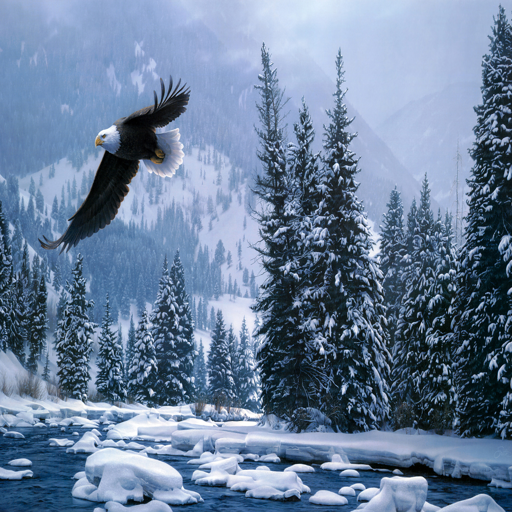

In [58]:
dest = 'bird.jpg'
urls = search_images('high resolution eagle in forest photo',2)
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest).resize((512,512))
im

In [53]:
latent = pil_to_latent(im)
latent.shape

torch.Size([1, 4, 64, 64])

In [ ]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent[0][c].cpu(), cmap='Greys')

  0%|          | 0/70 [00:00<?, ?it/s]

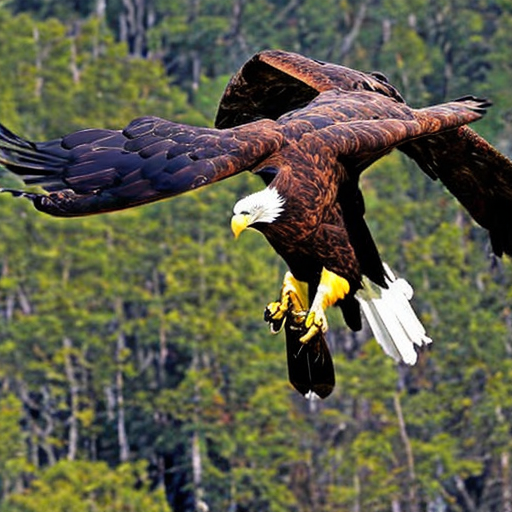

In [59]:
images = mk_samples(prompts,encoded = latent)

display(mk_img(images[0]))